In [11]:
# Import necessary libraries
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from collections import deque

import torch
import torch.nn as nn

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecMonitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.preprocessing import get_flattened_obs_dim
from stable_baselines3.common.callbacks import EvalCallback
from sb3_contrib import RecurrentPPO

from utils.fetch_data_with_indicators import Api, fetch_data_with_indicators

In [12]:
# ====================================
# Load Data
# ====================================

data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2015-01-01', '2023-01-01', '1d', ['RSI', 'EMA_50'])

data = data.copy()  # Make a full copy
data['Pct Change'] = data['Close'].pct_change() * 100
data.dropna(inplace=True)

# Define number of features (used in observation space)
num_features = 5

# ====================================
# Custom Environment Definition
# ====================================


class CryptoTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=1000, render_mode='human', fixed_episode_length=100):
        super(CryptoTradingEnv, self).__init__()

        # Initialize data and trading variables
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.render_mode = render_mode
        self.fixed_episode_length = fixed_episode_length  # Set a fixed length for each episode
        self.current_step = 1

        # History of actions
        self.actions_history = self.df[['Close', 'RSI']].copy()
        self.actions_history['Action'] = 0

        # Trading-specific variables
        self.trade_fee = 0.001
        self._last_reward = 0
        self._last_action = 0
        self._balance_pct_buy = 0.1
        self._avg_buy_price = 0
        self._avg_sell_price = 0
        self.balance = initial_balance
        self.crypto_held = 0
        self.net_worth = initial_balance

        # Define action space: Hold, Buy, Sell
        self.action_space = spaces.Discrete(3)

        # Define observation space: market data and portfolio information
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32)

        # Initialize random seed
        self._seed()

    def _seed(self, seed=None):
        np.random.seed(seed)

    def reset(self, seed=None):
        super().reset(seed=seed)

        # Reset trading variables
        self.balance = self.initial_balance
        self.crypto_held = 0
        self.net_worth = self.initial_balance
        self.actions_history = self.df[['Close', 'RSI']].copy()
        self.actions_history['Action'] = 0

        # Reset internal tracking variables
        self._last_reward = 0
        self._last_action = 0
        self._balance_pct_buy = 0.1
        self._avg_buy_price = 0
        self._avg_sell_price = 0

        # Set a random start point such that the episode will stay within the data bounds
        self.start_index = np.random.randint(0, len(self.df) - self.fixed_episode_length)
        self.current_step = self.start_index

        return self._get_observation(), {}

    def _get_price_features(self, index):
        # Extract relevant features from the dataframe
        return self.df.loc[index, ['Close', 'Volume', 'RSI', 'EMA_50', 'Pct Change']].values.astype(np.float32)

    def _get_observation(self):
        # Concatenate market features with portfolio state information
        concatenated = np.concatenate([self._get_price_features(self.current_step), np.array([
            self.balance,
            self.crypto_held,
            self.net_worth,
        ], dtype=np.float32)])

        return concatenated

    def _get_info(self):
        # Get current state information
        return dict(
            balance=self.balance,
            crypto_held=self.crypto_held,
            net_worth=self.net_worth,
            actions_history=self.actions_history,
        )

    def step(self, action):
        # Check if we are at the end of the episode length
        if self.current_step >= self.start_index + self.fixed_episode_length or self.current_step >= len(self.df) - 1:
            return self._get_observation(), 0, True, False, self._get_info()

        # Execute the action
        self._take_action(action)
        self.actions_history.loc[self.current_step, 'Action'] = action
        self.current_step += 1

        # Reward calculation based on price change and action taken
        current_price = self.df.loc[self.current_step, 'Close']
        last_price = self.df.loc[self.current_step - 1, 'Close']
        price_change = (current_price - last_price) / last_price

          # Calculate reward based on portfolio value change
        old_net_worth = self.net_worth
        new_net_worth = self.balance + (self.crypto_held * current_price)
        reward = ((new_net_worth - old_net_worth) / old_net_worth) * 100  # Percentage change

        # Small penalty for holding to encourage action
        if action == 0:  # Hold
            reward -= 0.1
            
        # Update the last reward and action
        self._last_reward = reward
        self._last_action = action

        # Check if the episode is done (e.g., if net worth falls below a certain threshold)
        done = False
        if self.net_worth <= self.initial_balance * 0.5:
            done = True

        return self._get_observation(), reward, done, False, self._get_info()

    def _take_action(self, action):
        # Get the current price
        current_price = self.df.loc[self.current_step, 'Close']

        if action == 1:  # Buy
            # Buy as much as possible with the available balance
            balance_to_buy = self.balance * 1
            crypto_can_buy = balance_to_buy / current_price
            self._avg_buy_price = (self._avg_buy_price + current_price) / 2

            self.crypto_held += crypto_can_buy
            self.balance -= crypto_can_buy * current_price

        elif action == 2:  # Sell
            # Sell all held crypto
            amount_to_sell = self.crypto_held * 1
            self._avg_sell_price = (self._avg_sell_price + current_price) / 2

            self.balance += (amount_to_sell * current_price)
            self.crypto_held -= amount_to_sell

        # Update net worth after the action
        self.net_worth = self.balance + self.crypto_held * current_price

    def render(self, mode='human'):
        # Print the current step, net worth, balance, and crypto held
        print(f'Step: {self.current_step}, Net Worth: {self.net_worth}, Balance: {self.balance}, Crypto Held: {self.crypto_held}, Last Reward: {self._last_reward}, Last Action: {self._last_action}, Avg Buy Price: {self._avg_buy_price}, Avg Sell Price: {self._avg_sell_price}') 

[*********************100%***********************]  1 of 1 completed


In [13]:
import torch
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from gymnasium import spaces

class TradingFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 128):
        super().__init__(observation_space, features_dim)
        
        n_input_features = observation_space.shape[0]
        
        # Process market features
        self.market_net = nn.Sequential(
            nn.Linear(n_input_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        
        # Optional attention mechanism for feature importance
        self.attention = nn.Sequential(
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
            nn.Softmax(dim=1)
        )
        
        # Final projection
        self.projection = nn.Linear(32, features_dim)
    

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # Process market features
        features = self.market_net(observations)
        
        # Apply attention
        attention_weights = self.attention(features)
        features = features * attention_weights 
        
        # Project to final dimension
        return self.projection(features)


In [138]:
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import DummyVecEnv
from stable_baselines3.common.vec_env import VecNormalize, VecMonitor

# Policy kwargs to use the custom CNN feature extractor
policy_kwargs = dict(
    features_extractor_class=TradingFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=128),  # Output dimension of the feature extractor
    normalize_images=False,  # Since we are not dealing with image data
)

# Setting up the environment
env = DummyVecEnv([lambda: CryptoTradingEnv(data)])  # Wrapping custom environment
env = VecNormalize(env, norm_obs=True, norm_reward=True)
env = VecMonitor(env)

# Optional: check the environment for errors
from stable_baselines3.common.env_checker import check_env
check_env(env.envs[0])

# Callback for evaluation
eval_callback = EvalCallback(env, best_model_save_path='./models/',
                             log_path='./tensorboard_logs/', eval_freq=1000,
                             deterministic=True, render=False, verbose=1)

# Creating the RecurrentPPO model with the custom feature extractor
model = RecurrentPPO(
    'MlpLstmPolicy',  # LSTM-based policy
    env, 
    learning_rate=0.0002, 
    policy_kwargs=policy_kwargs,
    verbose=1, 
    tensorboard_log="./tensorboard_logs/",
    n_steps=1024,  # Length of each rollout
    batch_size=64,  # Batch size for training the model
    n_epochs=10,  # Number of epochs for each update
    gamma=0.98,  # Discount factor
)

# Start training the model
model.learn(total_timesteps=30_000, callback=eval_callback, log_interval=1000)


Using cuda device
Logging to ./tensorboard_logs/RecurrentPPO_22
Eval num_timesteps=1000, episode_reward=1.31 +/- 1.69
Episode length: 101.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 101      |
|    mean_reward     | 1.31     |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-0.86 +/- 0.02
Episode length: 101.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 101         |
|    mean_reward          | -0.856      |
| time/                   |             |
|    total_timesteps      | 2000        |
| train/                  |             |
|    approx_kl            | 0.010096091 |
|    clip_fraction        | 0.0659      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.04725623  |

[*********************100%***********************]  1 of 1 completed

Step: 1, Net Worth: 1000.0, Balance: 0.0, Crypto Held: 0.01542527730551256, Last Reward: -1.1298352821403683, Last Action: 1, Avg Buy Price: 32414.328125, Avg Sell Price: 0
Step: 2, Net Worth: 988.7016471785963, Balance: 0.0, Crypto Held: 0.01542527730551256, Last Reward: 0.2439753185930799, Last Action: 1, Avg Buy Price: 48255.263671875, Avg Sell Price: 0
Step: 3, Net Worth: 991.1138351722353, Balance: 0.0, Crypto Held: 0.01542527730551256, Last Reward: -1.6680750893993759, Last Action: 1, Avg Buy Price: 56253.9208984375, Avg Sell Price: 0
Step: 4, Net Worth: 974.5813121801365, Balance: 0.0, Crypto Held: 0.01542527730551256, Last Reward: -4.595356431233688, Last Action: 1, Avg Buy Price: 59717.35888671875, Avg Sell Price: 0
Step: 5, Net Worth: 929.7958271732649, Balance: 0.0, Crypto Held: 0.01542527730551256, Last Reward: 2.5336630415439942, Last Action: 1, Avg Buy Price: 59997.386474609375, Avg Sell Price: 0
Step: 6, Net Worth: 953.3537204081722, Balance: 0.0, Crypto Held: 0.01542527

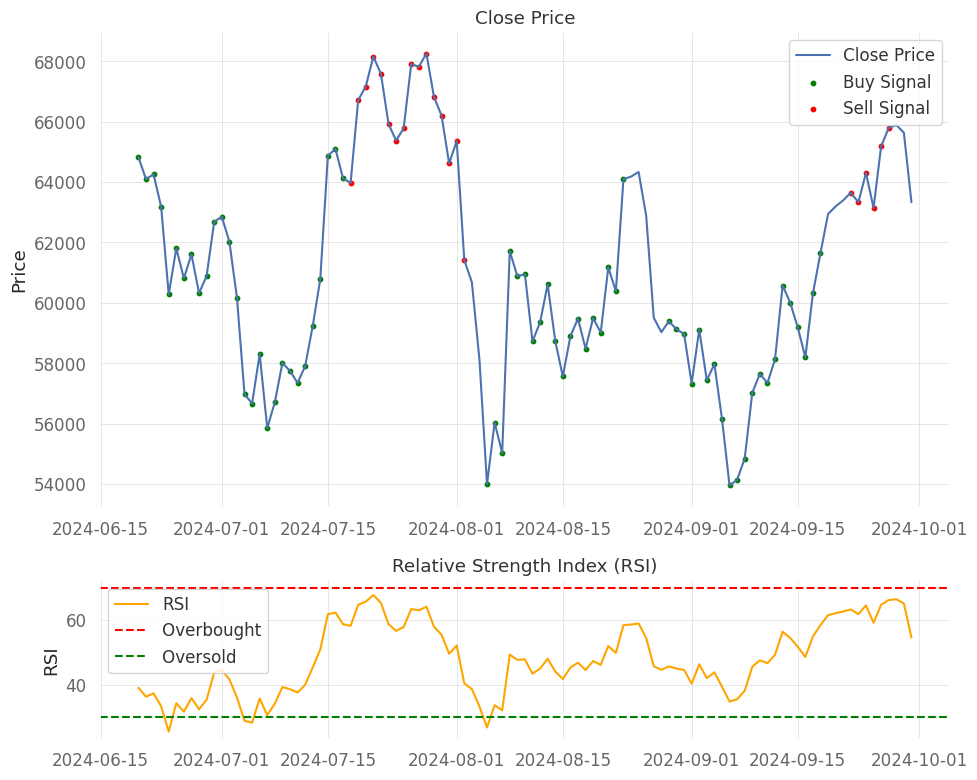

                    Strategy
------------------  ----------
Start Period        2024-06-20
End Period          2024-09-28
Risk-Free Rate      0.0%
Time in Market      76.0%

Cumulative Return   16.33%
CAGR﹪              46.41%

Sharpe              1.16
Prob. Sharpe Ratio  77.71%
Sortino             1.97
Sortino/√2          1.39
Omega               1.26

Max Drawdown        -16.14%
Longest DD Days     34

Gain/Pain Ratio     0.26
Gain/Pain (1M)      5.79

Payoff Ratio        1.07
Profit Factor       1.26
Common Sense Ratio  1.3
CPC Index           0.73
Tail Ratio          1.04
Outlier Win Ratio   5.01
Outlier Loss Ratio  2.64

MTD                 7.93%
3M                  22.42%
6M                  16.33%
YTD                 16.33%
1Y                  16.33%
3Y (ann.)           46.41%
5Y (ann.)           46.41%
10Y (ann.)          46.41%
All-time (ann.)     46.41%

Avg. Drawdown       -8.05%
Avg. Drawdown Days  19
Recovery Factor     1.12
Ulcer Index         0.07
Serenity Index      0.5

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


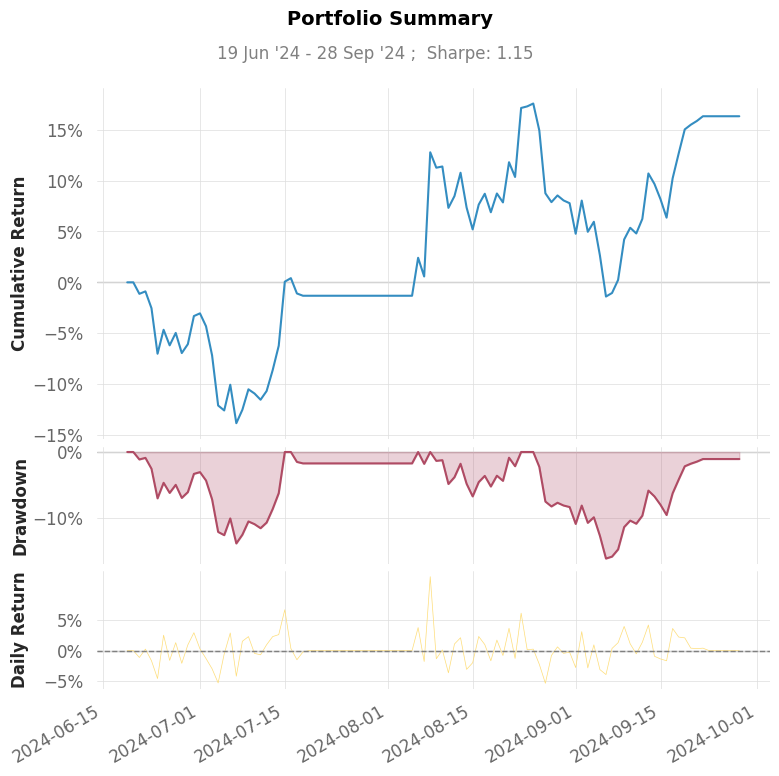

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


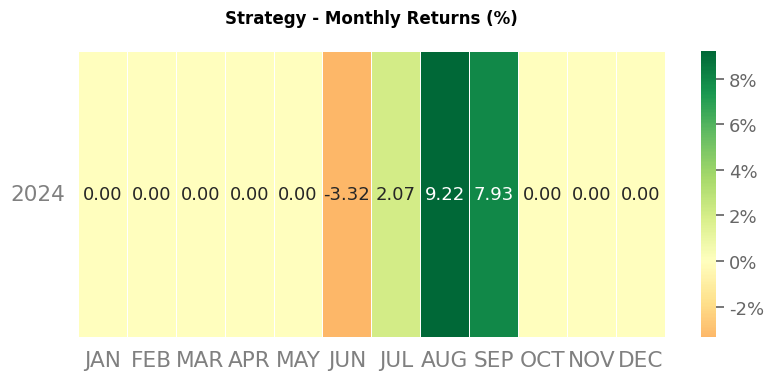

In [139]:
import quantstats as qs

from utils.charts.plot_data_with_rsi import plot_data_with_rsi

# ====================================
# Model Evaluation (Optional)
# ====================================

test_data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2024-05-01', '2024-10-01', '1d', ['RSI', 'EMA_50'])

test_data = test_data.copy()  # Make a full copy
test_data['Pct Change'] = test_data['Close'].pct_change() * 100
test_data.dropna(inplace=True)

eval_env = DummyVecEnv([lambda: CryptoTradingEnv(test_data)])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)

portfolio_values = []

model = RecurrentPPO.load('./models/best_model')

obs = eval_env.reset()
done = False
state = None
episode_starts = np.ones((1,), dtype=bool)
while not done:
    action, state = model.predict(obs, state=state, deterministic=True, episode_start=episode_starts)
    obs, reward, done, info = eval_env.step(action)
    
    portfolio_values.append(info[0]['net_worth'])   
    
    eval_env.render()
    
    episode_starts = done
    
    if done:
        actions_history = info[0]['actions_history']
        print('Episode done!')
    
eval_env.close()

# ====================================
# Portfolio Analysis
# ====================================

actions_history.index = pd.to_datetime(test_data.index)

plot_data_with_rsi(actions_history)

dates = pd.date_range(start=test_data.index[0], periods=len(portfolio_values), freq="D")
portfolio_series = pd.Series(portfolio_values, index=dates)

returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)



In [149]:
import torch
import torch.nn as nn
import numpy as np
import onnx
import onnxruntime as ort

class RecurrentModelWrapper(nn.Module):
    def __init__(self, policy):
        super(RecurrentModelWrapper, self).__init__()
        self.features_extractor = policy.features_extractor.to('cpu')
        self.mlp_extractor = policy.mlp_extractor.to('cpu')
        self.lstm_actor = policy.lstm_actor.to('cpu')
        self.lstm_critic = policy.lstm_critic.to('cpu')
        self.action_net = policy.action_net.to('cpu')
        self.value_net = policy.value_net.to('cpu')
        self.hidden_size_actor = policy.lstm_actor.hidden_size
        self.hidden_size_critic = policy.lstm_critic.hidden_size

    def forward(self, observations, lstm_actor_states, lstm_critic_states, episode_starts):
        # Reset LSTM states at episode starts
        if episode_starts is not None:
            reset_mask = 1 - episode_starts.unsqueeze(0).unsqueeze(-1)
            lstm_actor_states = tuple(state * reset_mask for state in lstm_actor_states)
            lstm_critic_states = tuple(state * reset_mask for state in lstm_critic_states)
            
        # Extract shared features
        features = self.features_extractor(observations)  # [batch_size, 128]
        
        features = features.unsqueeze(0)  # [1, batch_size, 128]
        lstm_output_actor, new_lstm_actor_states = self.lstm_actor(
            features, lstm_actor_states
        )  # lstm_output_actor: [1, batch_size, 256]

        lstm_output_critic, new_lstm_critic_states = self.lstm_critic(
            features, lstm_critic_states
        )  # lstm_output_critic: [1, batch_size, 256]
        
        # Pass through MLP extractor
        policy_features = self.mlp_extractor.policy_net(lstm_output_actor.squeeze(0))  # [batch_size, 64]
        value_features = self.mlp_extractor.value_net(lstm_output_critic.squeeze(0))    # [batch_size, 64]
        
        # Get action logits and value
        action_logits = self.action_net(policy_features)  # [batch_size, 3]
        value = self.value_net(value_features)            # [batch_size, 1]
        
        return action_logits, value, new_lstm_actor_states, new_lstm_critic_states

model = RecurrentPPO.load('./models/best_model', device='cpu')
wrapped_model = RecurrentModelWrapper(model.policy)
wrapped_model.eval()

# Define dummy input dimensions
batch_size = 1
feature_dim = 8  # As per your Linear layer's in_features

# Dummy observation tensor [batch_size, feature_dim]
dummy_obs = torch.randn(batch_size, feature_dim, dtype=torch.float32, device='cpu')

# Dummy LSTM states for actor [num_layers, batch_size, hidden_size]
num_layers_actor = wrapped_model.lstm_actor.num_layers
hidden_size_actor = wrapped_model.hidden_size_actor

dummy_lstm_actor_h = torch.randn(num_layers_actor, batch_size, hidden_size_actor, dtype=torch.float32, device='cpu')
dummy_lstm_actor_c = torch.randn(num_layers_actor, batch_size, hidden_size_actor, dtype=torch.float32, device='cpu')

# Dummy LSTM states for critic [num_layers, batch_size, hidden_size]
num_layers_critic = wrapped_model.lstm_critic.num_layers
hidden_size_critic = wrapped_model.hidden_size_critic

dummy_lstm_critic_h = torch.randn(num_layers_critic, batch_size, hidden_size_critic, dtype=torch.float32, device='cpu')
dummy_lstm_critic_c = torch.randn(num_layers_critic, batch_size, hidden_size_critic, dtype=torch.float32, device='cpu')

dummy_lstm_actor_states = (dummy_lstm_actor_h, dummy_lstm_actor_c)
dummy_lstm_critic_states = (dummy_lstm_critic_h, dummy_lstm_critic_c)

# Dummy episode starts tensor [batch_size]
dummy_episode_starts = torch.zeros(batch_size, dtype=torch.float32, device='cpu')

# Export the model to ONNX
torch.onnx.export(
    wrapped_model,  # The model to be exported
    (
        dummy_obs, 
        dummy_lstm_actor_states, 
        dummy_lstm_critic_states, 
        dummy_episode_starts
    ),  # The model's input
    "recurrent_actor_critic_policy.onnx",  # Where to save the model
    export_params=True,
    opset_version=12,  # Ensure compatibility with ONNX
    do_constant_folding=True,
    input_names=[
        'observations', 
        'lstm_actor_h', 'lstm_actor_c', 
        'lstm_critic_h', 'lstm_critic_c', 
        'episode_starts'
    ],
    output_names=[
        'action_logits', 
        'value', 
        'new_lstm_actor_h', 'new_lstm_actor_c', 
        'new_lstm_critic_h', 'new_lstm_critic_c'
    ],
    dynamic_axes={
        'observations': {0: 'batch_size'},
        'lstm_actor_h': {1: 'batch_size'},
        'lstm_actor_c': {1: 'batch_size'},
        'lstm_critic_h': {1: 'batch_size'},
        'lstm_critic_c': {1: 'batch_size'},
        'episode_starts': {0: 'batch_size'},
        'action_logits': {0: 'batch_size'},
        'value': {0: 'batch_size'},
        'new_lstm_actor_h': {1: 'batch_size'},
        'new_lstm_actor_c': {1: 'batch_size'},
        'new_lstm_critic_h': {1: 'batch_size'},
        'new_lstm_critic_c': {1: 'batch_size'},
    }
)

print("Model was successfully exported to ONNX format as 'recurrent_actor_critic_policy.onnx'")


# Load the ONNX model
onnx_model = onnx.load("recurrent_actor_critic_policy.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid.")

# Create an inference session
session = ort.InferenceSession("recurrent_actor_critic_policy.onnx")

# Prepare test inputs
test_obs = np.random.randn(batch_size, feature_dim).astype(np.float32)

test_lstm_actor_h = np.random.randn(num_layers_actor, batch_size, hidden_size_actor).astype(np.float32)
test_lstm_actor_c = np.random.randn(num_layers_actor, batch_size, hidden_size_actor).astype(np.float32)

test_lstm_critic_h = np.random.randn(num_layers_critic, batch_size, hidden_size_critic).astype(np.float32)
test_lstm_critic_c = np.random.randn(num_layers_critic, batch_size, hidden_size_critic).astype(np.float32)

test_episode_starts = np.zeros(batch_size, dtype=np.float32)

# Define the input dictionary
ort_inputs = {
    'observations': test_obs,
    'lstm_actor_h': test_lstm_actor_h,
    'lstm_actor_c': test_lstm_actor_c,
    'lstm_critic_h': test_lstm_critic_h,
    'lstm_critic_c': test_lstm_critic_c,
    'episode_starts': test_episode_starts
}

# Run inference
ort_outputs = session.run(
    ['action_logits', 'value', 'new_lstm_actor_h', 'new_lstm_actor_c', 'new_lstm_critic_h', 'new_lstm_critic_c'], 
    ort_inputs
)

# Extract outputs
action_logits, value, new_lstm_actor_h, new_lstm_actor_c, new_lstm_critic_h, new_lstm_critic_c = ort_outputs

# Display results
predicted_action = np.argmax(action_logits[0])
print("Action logits:", action_logits)
print("Value estimate:", value)
print("Predicted action:", predicted_action)
print("New LSTM Actor Hidden State shape:", new_lstm_actor_h.shape)
print("New LSTM Actor Cell State shape:", new_lstm_actor_c.shape)
print("New LSTM Critic Hidden State shape:", new_lstm_critic_h.shape)
print("New LSTM Critic Cell State shape:", new_lstm_critic_c.shape)


Model was successfully exported to ONNX format as 'recurrent_actor_critic_policy.onnx'
ONNX model is valid.
Action logits: [[-0.5838014  -0.17335328  0.76668745]]
Value estimate: [[-0.36270577]]
Predicted action: 2
New LSTM Actor Hidden State shape: (1, 1, 256)
New LSTM Actor Cell State shape: (1, 1, 256)
New LSTM Critic Hidden State shape: (1, 1, 256)
New LSTM Critic Cell State shape: (1, 1, 256)


/home/tommy/Downloads/ai-playground/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [147]:
import numpy as np
import onnxruntime as ort
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Load test data
test_data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2024-05-01', '2024-10-01', '1d', ['RSI', 'EMA_50'])
test_data = test_data.copy()
test_data['Pct Change'] = test_data['Close'].pct_change() * 100
test_data.dropna(inplace=True)

# Prepare the environment
eval_env = DummyVecEnv([lambda: CryptoTradingEnv(test_data)])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)
obs = eval_env.reset()

# Load your trained model
model = RecurrentPPO.load('./models/best_model', device='cpu')

# Create an inference session for the ONNX model
session = ort.InferenceSession("recurrent_actor_critic_policy.onnx")

# Prepare LSTM states and episode starts
batch_size = obs.shape[0]
num_layers_actor = model.policy.lstm_actor.num_layers
hidden_size_actor = model.policy.lstm_actor.hidden_size
hidden_size_critic = model.policy.lstm_critic.hidden_size

lstm_actor_h = np.zeros((num_layers_actor, batch_size, hidden_size_actor), dtype=np.float32)
lstm_actor_c = np.zeros((num_layers_actor, batch_size, hidden_size_actor), dtype=np.float32)
lstm_critic_h = np.zeros((num_layers_actor, batch_size, hidden_size_critic), dtype=np.float32)
lstm_critic_c = np.zeros((num_layers_actor, batch_size, hidden_size_critic), dtype=np.float32)
episode_starts = np.zeros(batch_size, dtype=np.float32)  # Ensure this is 1-dimensional

print(episode_starts.shape)
# Define the input dictionary for ONNX
ort_inputs = {
    'observations': obs.astype(np.float32),
    'lstm_actor_h': lstm_actor_h,
    'lstm_actor_c': lstm_actor_c,
    'lstm_critic_h': lstm_critic_h,
    'lstm_critic_c': lstm_critic_c,
    'episode_starts': episode_starts  # Ensure this is 1-dimensional
}

# Run inference with both models
done = False
state = None
while not done:
    # PyTorch model prediction
    action, state = model.predict(obs, state=state, deterministic=True)
    
    # ONNX model prediction
    ort_outputs = session.run(
        ['action_logits', 'value', 'new_lstm_actor_h', 'new_lstm_actor_c', 'new_lstm_critic_h', 'new_lstm_critic_c'], 
        ort_inputs
    )
    onnx_action_logits, onnx_value, onnx_new_lstm_actor_h, onnx_new_lstm_actor_c, onnx_new_lstm_critic_h, onnx_new_lstm_critic_c = ort_outputs
    onnx_predicted_action = np.argmax(onnx_action_logits, axis=1)

    # Compare the outputs
    print("PyTorch Action:", action)
    print("ONNX Action Logits:", onnx_action_logits)
    print("ONNX Predicted Action:", onnx_predicted_action)
    print("ONNX Value:", onnx_value)

    # Step through the environment using the PyTorch action
    obs, reward, done, info = eval_env.step(action)
    eval_env.render()

    # Update ONNX inputs for the next step
    ort_inputs['observations'] = obs.astype(np.float32)
    ort_inputs['lstm_actor_h'] = onnx_new_lstm_actor_h
    ort_inputs['lstm_actor_c'] = onnx_new_lstm_actor_c
    ort_inputs['lstm_critic_h'] = onnx_new_lstm_critic_h
    ort_inputs['lstm_critic_c'] = onnx_new_lstm_critic_c
    
    ort_inputs['episode_starts'] = done.astype(np.float32)  # Ensure this is 1-dimensional
    print( ort_inputs['episode_starts'])

eval_env.close()

[*********************100%***********************]  1 of 1 completed


(1,)
PyTorch Action: [1]
ONNX Action Logits: [[-0.15475133  0.2656253  -0.12570676]]
ONNX Predicted Action: [1]
ONNX Value: [[0.088037]]
Step: 2, Net Worth: 1000.0, Balance: 0.0, Crypto Held: 0.015601549111939714, Last Reward: 0.243975318593084, Last Action: 1, Avg Buy Price: 32048.099609375, Avg Sell Price: 0
[0.]
PyTorch Action: [1]
ONNX Action Logits: [[-0.2702181   0.44335094 -0.18613635]]
ONNX Predicted Action: [1]
ONNX Value: [[0.14933796]]
Step: 3, Net Worth: 1002.4397531859308, Balance: 0.0, Crypto Held: 0.015601549111939714, Last Reward: -1.6680750893993839, Last Action: 1, Avg Buy Price: 48150.3388671875, Avg Sell Price: 0
[0.]
PyTorch Action: [1]
ONNX Action Logits: [[-0.0762094  0.9788606 -0.9605055]]
ONNX Predicted Action: [1]
ONNX Value: [[0.53888965]]
Step: 4, Net Worth: 985.7183053767997, Balance: 0.0, Crypto Held: 0.015601549111939714, Last Reward: -4.5953564312336725, Last Action: 1, Avg Buy Price: 55665.56787109375, Avg Sell Price: 0
[0.]
PyTorch Action: [1]
ONNX Act

In [14]:
from ic.client import Client
from ic.identity import Identity
from ic.agent import Agent
from ic.candid import encode, Types
from meta.custom_env import CustomEnv
from utils.fetch_data_with_indicators import Api, fetch_data_with_indicators
from utils.plot_buy_and_sell import plot_buy_and_sell
import numpy as np
from typing import List
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Constants
CANISTER_ID = "bkyz2-fmaaa-aaaaa-qaaaq-cai"
IC_URL = "http://127.0.0.1:4943"
OK_KEY = '_17724'
BUY_KEY = '_803992927'
HOLD_KEY = '_3308326'
SELL_KEY = '_925480882'

DECODE_DICT = {
    BUY_KEY: 0,
    HOLD_KEY: 1,
    SELL_KEY: 2
}


def decode_action(response):
    """Decode action from IC canister response"""
    result_variant = response[0]['value']
    if list(result_variant.keys())[0] != OK_KEY:
        raise ValueError("Invalid response")
    action_variant = DECODE_DICT[list(result_variant[OK_KEY].keys())[0]]
    return action_variant

def predict_ic(observation: np.ndarray) -> int:
    """Get prediction from IC canister"""
    observation = observation.astype(np.float32)
    input_list = observation.tolist()
    params = [{"type": Types.Vec(Types.Float32), "value": input_list}]
    
    client = Client(url=IC_URL)
    identity = Identity()
    agent = Agent(identity, client)
    
    response = agent.update_raw(CANISTER_ID, "get_action", encode(params))
    return decode_action(response)
  
  
def test_ic_model(env: CustomEnv) -> List[float]:
    """Test the IC canister model"""
    observation, info = env.reset()
    portfolio_values = []
    
    while True:
        action = predict_ic(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        portfolio_values.append(info['portfolio_value'])
        
        if terminated or truncated:
            break
    
    return portfolio_values 


import quantstats as qs

from utils.charts.plot_data_with_rsi import plot_data_with_rsi

# ====================================
# Model Evaluation (Optional)
# ====================================

test_data = fetch_data_with_indicators(Api.YAHOO, 'BTC-USD', '2024-05-01', '2024-10-01', '1d', ['RSI', 'EMA_50'])

test_data = test_data.copy()  # Make a full copy
test_data['Pct Change'] = test_data['Close'].pct_change() * 100
test_data.dropna(inplace=True)

eval_env = DummyVecEnv([lambda: CryptoTradingEnv(test_data)])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False)

portfolio_values = []
obs = eval_env.reset()
done = False

while not done:
    # Get prediction from IC canister
    action = predict_ic(obs[0])  # Use obs[0] since env is vectorized
    
    # Step through environment
    obs, reward, done, info = eval_env.step([action])  # Wrap action in list for vectorized env
    portfolio_values.append(info[0]['net_worth'])
    
    eval_env.render()
    
    if done:
        actions_history = info[0]['actions_history']
        print('Episode done!')

eval_env.close()

# Portfolio Analysis
actions_history.index = pd.to_datetime(test_data.index)
plot_data_with_rsi(actions_history)

dates = pd.date_range(start=test_data.index[0], periods=len(portfolio_values), freq="D")
portfolio_series = pd.Series(portfolio_values, index=dates)
returns = portfolio_series.pct_change().fillna(0)

qs.reports.basic(returns)

[*********************100%***********************]  1 of 1 completed

TypeError: byte indices must be integers or slices, not str